Proyecto 1

Imanol Muñiz Ramirez A01701713

María José Soto

Rodrigo

Provide understanding of the candy category by manufacturermarket share composition by year

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Cargar datos
try:
    df_catalog = pd.read_csv('./DATA_CATALOG_2024.csv', encoding='latin1')
    df_sales = pd.read_csv('./DATOS_VENTA_2024.csv')
    print("Archivos de datos cargados exitosamente.")
except FileNotFoundError:
    print("Error: Los archivos 'DATA_CATALOG_2024.csv' o 'DATOS_VENTA_2024.csv' no se encontraron.")
    print("Asegúrate de que estén en la misma carpeta que el script y vuelve a intentarlo.")
    exit()

Archivos de datos cargados exitosamente.


Limpieza y merge de los datos

In [ ]:
print("\n--- Analizando datos de ventas y mercado ---")

# Agregar ventas por ID y año
df_yearly = (
    df_sales
    .groupby(['ID', 'ANIO'], as_index=False)['VALOR']
    .sum()
)

# Pivotear la tabla para tener años como columnas
df_pivot = df_yearly.pivot(index='ID', columns='ANIO', values='VALOR').reset_index()
df_pivot.columns = [str(c) for c in df_pivot.columns]
df_final = df_catalog.merge(df_pivot, on='ID', how='left').fillna(0)

# Filtrar por la categoría 'CANDY'
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas anuales
df_candy_fab = (
    df_candy.groupby('FAB')[['2020', '2021', '2022', '2023', '2024']]
    .sum()
    .reset_index()
)

Filtrado y generación de nuevas columnas

In [20]:
# Filtrar solo CANDY
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas
df_candy_fab = (
    df_candy.groupby('FAB')[['2020','2021','2022','2023','2024']]
    .sum()
    .reset_index()
)

# Calcular el total acumulado de cada fabricante en todos los años
df_candy_fab['TOTAL'] = df_candy_fab[['2020','2021','2022','2023','2024']].sum(axis=1)

# Ordenar fabricantes por ventas totales
df_candy_fab = df_candy_fab.sort_values(by='TOTAL', ascending=False)

# Calcular participación porcentual y acumulada
df_candy_fab['SHARE'] = df_candy_fab['TOTAL'] / df_candy_fab['TOTAL'].sum()
df_candy_fab['CUM_SHARE'] = df_candy_fab['SHARE'].cumsum()

# Filtrar solo fabricantes que conforman el 80% del mercado
df_candy_fab_top = df_candy_fab[df_candy_fab['CUM_SHARE'] <= 0.8].copy()

# Lista de fabricantes top 80%
top_fabs = df_candy_fab_top['FAB'].unique()

Gráficos

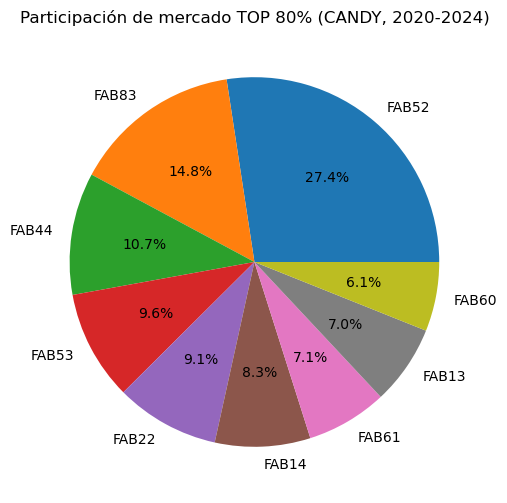

In [21]:
# --- Pie chart con top 80% ---
plt.figure(figsize=(8,6))
plt.pie(df_candy_fab_top['TOTAL'], labels=df_candy_fab_top['FAB'], autopct='%1.1f%%')
plt.title("Participación de mercado TOP 80% (CANDY, 2020-2024)")
plt.show()

FAB52 y FAB83 son las que tienen una mayor parte del mercado. Sobre todo FAB52 que tiene un 27.4% del 80% del mercado total.

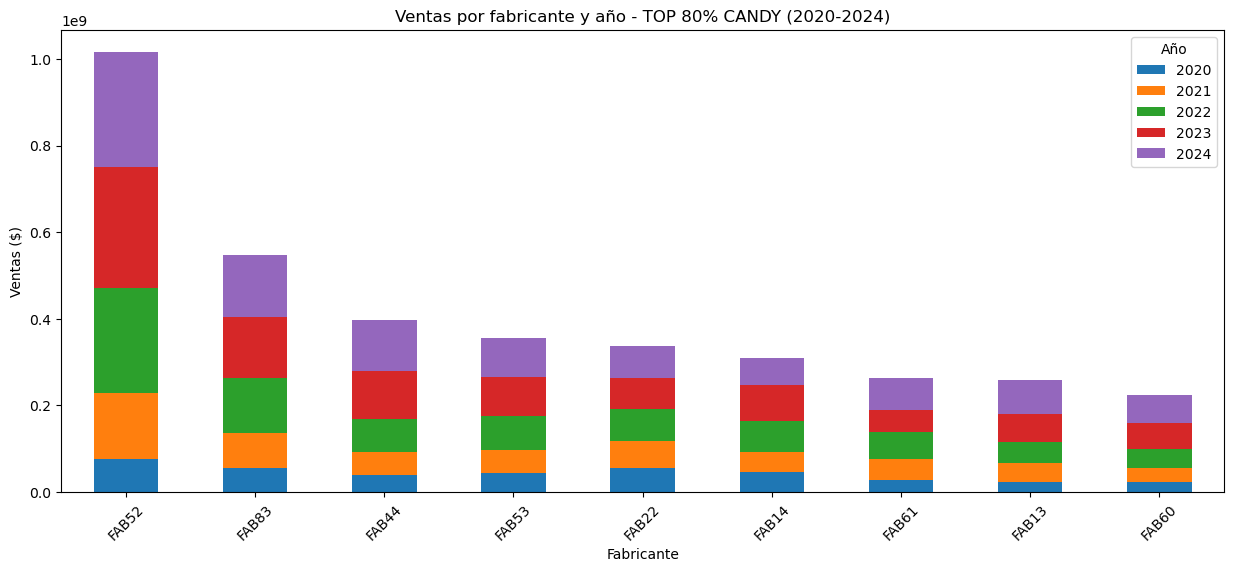

In [22]:
# --- Barras stacked por año solo top 80% ---
fig, ax = plt.subplots(figsize=(15,6))
df_candy_fab_top.set_index('FAB')[['2020','2021','2022','2023','2024']].plot(
    kind='bar', stacked=True, ax=ax
)

ax.set_title("Ventas por fabricante y año - TOP 80% CANDY (2020-2024)")
ax.set_xlabel("Fabricante")
ax.set_ylabel("Ventas ($)")
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.show()

df_candy_fab_top.to_csv('./CANDY_MARKET_SHARE.csv', index=False)

Para el año 2022, FAB52 ya vendía lo las demás FABs en el año 2024. FAB83 en el año 2023 vendía lo que las demás en el año 2024. 

Provide understanding of the candy category by manufacturer sales and price performance over time.

In [23]:
# --- Partimos de df_sales (todas las ventas) y df_catalog ---
# Filtrar solo CANDY
df_catalog_candy = df_catalog[df_catalog['CATEGORY'] == 'CANDY']

# Merge para quedarnos con info de FAB en las ventas
df_candy_sales = df_sales.merge(df_catalog_candy[['ID','FAB']], on='ID', how='inner')

# --- Limpieza de UNIDADES ---
df_candy_sales['UNIDADES'] = (
    df_candy_sales['UNIDADES']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Agrupar por FAB y ANIO ---
df_candy_perf = (
    df_candy_sales
    .groupby(['FAB','ANIO'], as_index=False)
    .agg({'VALOR':'sum','UNIDADES':'sum'})
)
df_candy_perf_top = df_candy_perf[df_candy_perf['FAB'].isin(top_fabs)]

# --- Calcular precio promedio ---
df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']

df_candy_perf_top.to_csv('./CANDY_SALES_PERF.csv', index=False)

C:\Users\majos\AppData\Local\Temp\ipykernel_60656\4196741909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']


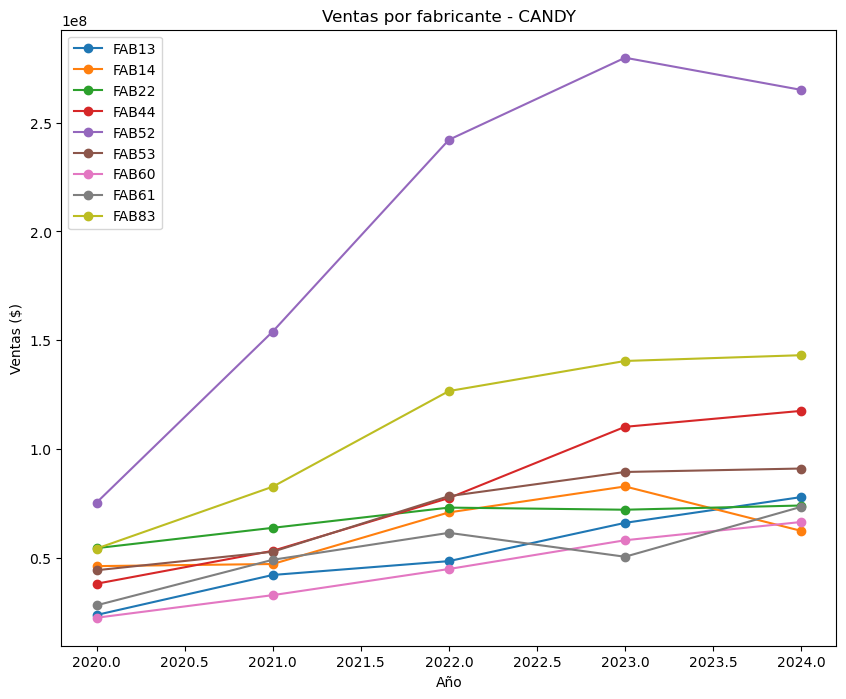

In [24]:
# Gráfico de líneas: ventas por año por fabricante
plt.figure(figsize=(10,8))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['VALOR'], marker='o', label=fab)

plt.title("Ventas por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()

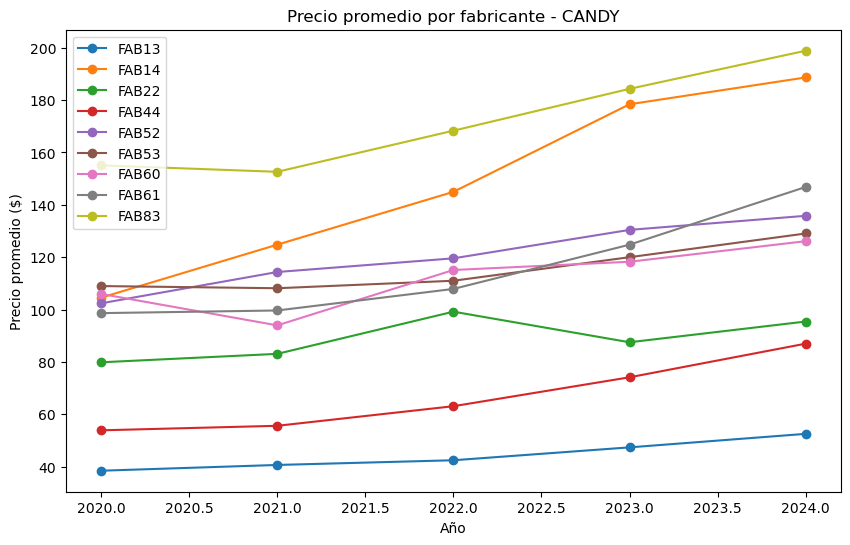

In [25]:
# Gráfico de líneas: precio promedio por año por fabricante
plt.figure(figsize=(10,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['PRECIO_PROM'], marker='o', label=fab)

plt.title("Precio promedio por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Precio promedio ($)")
plt.legend()
plt.show()

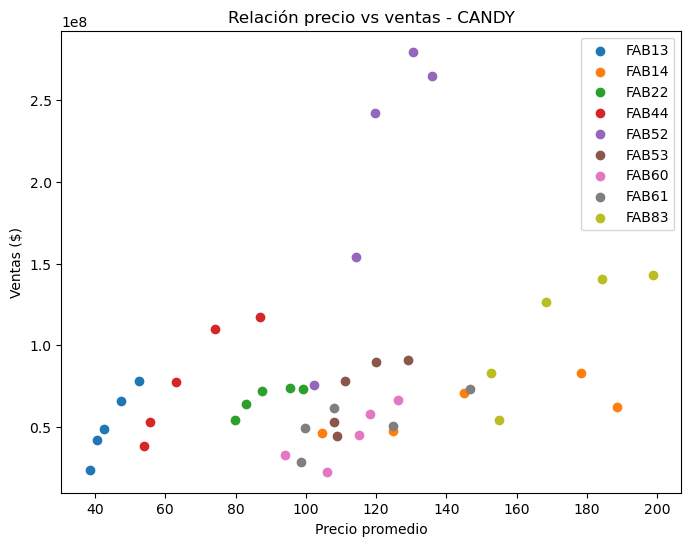

In [26]:
# Gráfico de dispersión: precio promedio vs ventas por fabricante
plt.figure(figsize=(8,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.scatter(subset['PRECIO_PROM'], subset['VALOR'], label=fab)

plt.title("Relación precio vs ventas - CANDY")
plt.xlabel("Precio promedio")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()

In [35]:
# ========================
# PARTE 2: Análisis de Demanda
# ========================

import statsmodels.api as sm
import seaborn as sns

# df_sales y df_catalog ya están cargados.

df_candy_sales['FECHA'] = pd.to_datetime(df_candy_sales['FECHA'])

# Agrupar por FAB y FECHA, y filtrar por top_fabs
df_fabricante = df_candy_sales[df_candy_sales['FAB'].isin(top_fabs)].groupby(['FAB', 'FECHA']).agg({
    'UNIDADES': 'sum',
    'VALOR': 'sum'
}).reset_index()

df_fabricante['PRECIO_PROMEDIO'] = df_fabricante['VALOR'] / df_fabricante['UNIDADES']
#display(df_fabricante)

df_fabricante_top = df_candy_sales[df_candy_sales['FAB'].isin(top_fabs)].groupby(['FAB']).agg({
    'UNIDADES': 'sum',
    'VALOR': 'sum'
}).reset_index()


In [38]:
ventas_t = df_fabricante_top['VALOR'].sum()
unidades_t = df_fabricante_top['UNIDADES'].sum()
df_fabricante_top['CUOTA_MERCADO_VALOR'] = ((df_fabricante_top['VALOR'] / ventas_t) * 100).round(2)
df_fabricante_top['CUOTA_MERCADO_UNIDADES'] = ((df_fabricante_top['UNIDADES'] / unidades_t) * 100).round(2)
df_fabricante_top = df_fabricante_top.sort_values(by='CUOTA_MERCADO_VALOR', ascending=False)
# df_fabricante_top.head()

df_modeling = df_fabricante.copy()
df_modeling = df_modeling[(df_modeling['UNIDADES'] > 0) & (df_modeling['PRECIO_PROMEDIO'] > 0)].copy()

df_modeling['ln_cantidad'] = np.log(df_modeling['UNIDADES'])
df_modeling['ln_precio'] = np.log(df_modeling['PRECIO_PROMEDIO'])

FABS = df_modeling['FAB'].unique()

resultados = {}

for FAB in FABS:
    df_fab_data = df_modeling[df_modeling['FAB'] == FAB].copy()

    if len(df_fab_data) > 1:
        y = df_fab_data['ln_cantidad']
        x = df_fab_data['ln_precio']
        x = sm.add_constant(x)

        model = sm.OLS(y, x).fit()

        interseccion = model.params['const']
        elasticidad = model.params['ln_precio']
        r2 = model.rsquared

        t_stat = model.tvalues['ln_precio']
        p_value = model.pvalues['ln_precio']
        conf_int = model.conf_int()

        resultados[FAB] = {
            'interseccion': interseccion,
            'coeficiente': elasticidad,
            'r2': r2,
            't_stat': t_stat,
            'p_value': p_value
        }


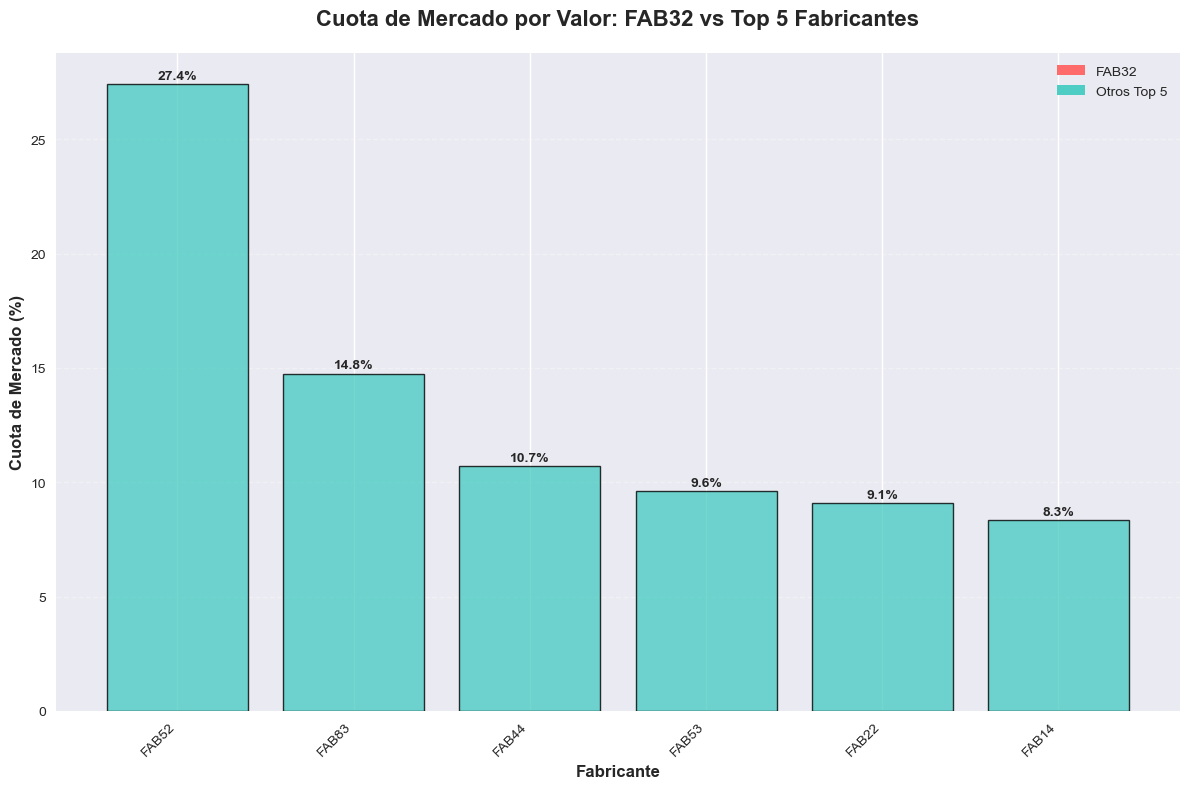

In [44]:
df_resultados = pd.DataFrame(resultados).T
df_resultados.head()


datos_grafico = df_fabricante_top.head(6)
plt.figure(figsize=(12, 8))

plt.style.use('seaborn-v0_8')
colors = ['#FF6B6B' if fab == 'FAB32' else '#4ECDC4' for fab in datos_grafico['FAB']]

bars = plt.bar(datos_grafico['FAB'],
               datos_grafico['CUOTA_MERCADO_VALOR'],
               color=colors,
               alpha=0.8,
               edgecolor='black',
               linewidth=1)

plt.title('Cuota de Mercado por Valor: FAB32 vs Top 5 Fabricantes',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fabricante', fontsize=12, fontweight='bold')
plt.ylabel('Cuota de Mercado (%)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', label='FAB32'),
                   Patch(facecolor='#4ECDC4', label='Otros Top 5')]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

COMPARACIÓN DE CUOTAS DE MERCADO
  FAB  CUOTA_MERCADO_VALOR  CUOTA_MERCADO_UNIDADES
FAB52                27.41                   22.86
FAB83                14.75                    8.71
FAB44                10.69                   15.96
FAB53                 9.60                    8.50
FAB22                 9.10                   10.55
FAB14                 8.34                    5.86


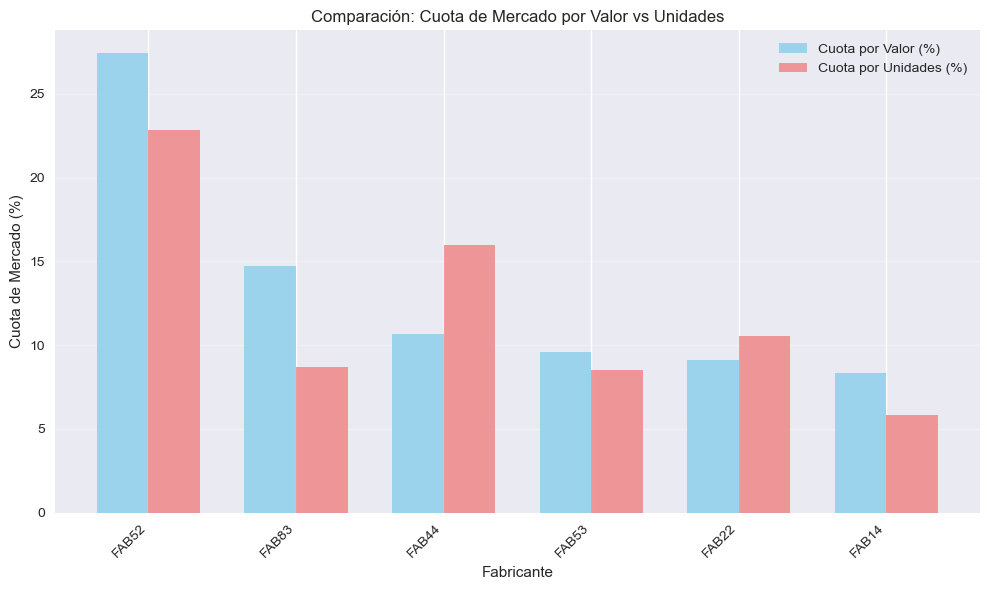

In [45]:


print("COMPARACIÓN DE CUOTAS DE MERCADO")
print("="*50)
print(datos_grafico[['FAB', 'CUOTA_MERCADO_VALOR', 'CUOTA_MERCADO_UNIDADES']].to_string(index=False))

plt.figure(figsize=(10, 6))
x = range(len(datos_grafico))
width = 0.35
plt.bar([i - width/2 for i in x], datos_grafico['CUOTA_MERCADO_VALOR'],
        width, label='Cuota por Valor (%)', color='skyblue', alpha=0.8)
plt.bar([i + width/2 for i in x], datos_grafico['CUOTA_MERCADO_UNIDADES'],
        width, label='Cuota por Unidades (%)', color='lightcoral', alpha=0.8)
plt.xlabel('Fabricante')
plt.ylabel('Cuota de Mercado (%)')
plt.title('Comparación: Cuota de Mercado por Valor vs Unidades')
plt.xticks(x, datos_grafico['FAB'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Parte 3
Considering ONLY the top 2 fabs, propose how you could improve your model(s) design to incorporate the following factors: cross-price elasticity, seasonality and growth trend.

In [ ]:
top2_fabs = df_candy_fab_top.head(2)['FAB'].tolist()
df_top2 = df_candy_perf_top[df_candy_perf_top['FAB'].isin(top2_fabs)].copy()

df_top2

# Pivot: years as index, FAB as columns
q_pivot = df_top2.pivot(index='ANIO', columns='FAB', values='UNIDADES')
p_pivot = df_top2.pivot(index='ANIO', columns='FAB', values='PRECIO_PROM')

dq = q_pivot.pct_change().dropna()
dp = p_pivot.pct_change().dropna()

In [ ]:
fab1, fab2 = top2_fabs

E_12 = (dq[fab1] / dp[fab2]).mean()   # elasticity of fab1 wrt fab2 price
E_21 = (dq[fab2] / dp[fab1]).mean()   # elasticity of fab2 wrt fab1 price

print(f"Cross-price elasticity of {fab1} wrt {fab2}: {E_12:.3f}")
print(f"Cross-price elasticity of {fab2} wrt {fab1}: {E_21:.3f}")


Cross-price elasticity of FAB52 wrt FAB83: -11.974
Cross-price elasticity of FAB83 wrt FAB52: 2.999


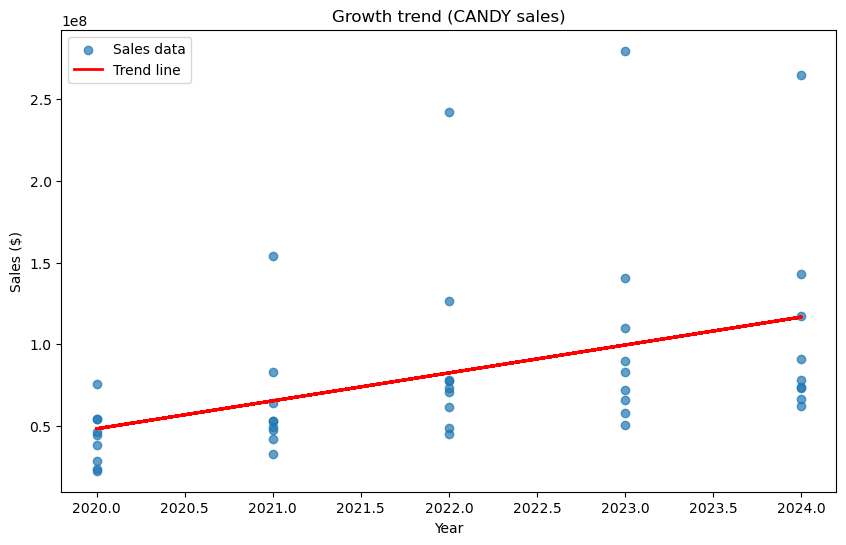

In [ ]:
# Scatter plot of sales by year
x = df_candy_perf_top['ANIO'].values
y = df_candy_perf_top['VALOR'].values

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.7, label="Sales data")

# Fit a linear regression (trend line)
coef = np.polyfit(x, y, 1)      # degree=1 → linear
poly1d_fn = np.poly1d(coef)     # build function from coefficients

plt.plot(x, poly1d_fn(x), color="red", linewidth=2, label="Trend line")

plt.title("Growth trend (CANDY sales)")
plt.xlabel("Year")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()

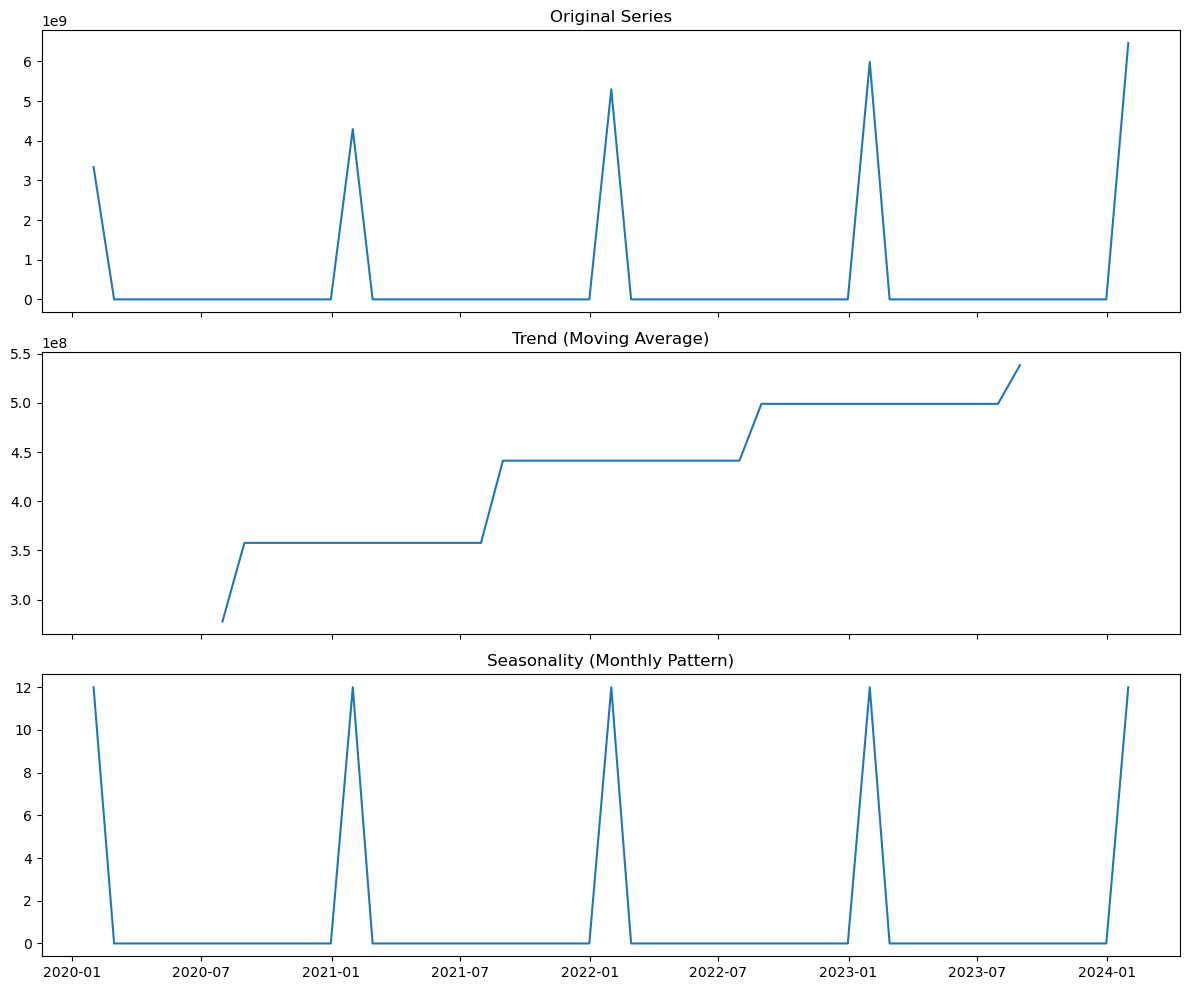

In [ ]:

df_monthly = df_sales.copy() 
df_monthly['FECHA'] = pd.to_datetime(df_monthly['FECHA']) 
df_monthly = df_monthly.groupby(pd.Grouper(key='FECHA', freq='M'))['VALOR'].sum().reset_index()
df_monthly['Trend'] = df_monthly['VALOR'].rolling(window=12, center=True).mean()

df_monthly['Detrended'] = df_monthly['VALOR'] / df_monthly['Trend']
df_monthly['Month'] = df_monthly['FECHA'].dt.month

# Average seasonal effect for each month
seasonal_factors = df_monthly.groupby('Month')['Detrended'].mean()
df_monthly['Seasonality'] = df_monthly['Month'].map(seasonal_factors)


fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axs[0].plot(df_monthly['FECHA'], df_monthly['VALOR'])
axs[0].set_title("Original Series")

axs[1].plot(df_monthly['FECHA'], df_monthly['Trend'])
axs[1].set_title("Trend (Moving Average)")

axs[2].plot(df_monthly['FECHA'], df_monthly['Seasonality'])
axs[2].set_title("Seasonality (Monthly Pattern)")


plt.tight_layout()
plt.show()
